# 02 - SnakeCLEF - High-level Exploration of the Training Dataset

In [1]:
import os

os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.core import data
from src.utils import visualization as viz


def plot_class_distribution(train_df, valid_df, *, title=None, ax=None):
    assert 'binomial' in train_df
    assert 'binomial' in valid_df

    if ax is None:
        fig, ax = viz.create_fig(ncols=1, nrows=1)

    train_df['binomial'].value_counts().plot(kind='area', label='Training Set', ax=ax)
    valid_df['binomial'].value_counts().plot(kind='area', label='Validation Set', ax=ax)
    ax.set(xticks=[], xlabel='Snake Species (classes)', ylabel='Image Counts', title=title)
    ax.legend()

    return ax


DATA_DIR = 'data/snake_clef2021_dataset/'
TRAIN_SET_DIR = 'train'

In [3]:
# load metadata
train_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_PROD.csv')
mini_train_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_mini_PROD.csv')
valid_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_test_metadata_annotated.csv')

## General Statistics

**Number of samples in the full dataset:**

In [4]:
len(train_df)

386006

**Number of samples in the mini-subset:**

In [5]:
len(mini_train_df)

70208

**Targets:**

In [6]:
len(train_df['binomial'].unique())

772

In [7]:
len(train_df['genus'].unique())

269

In [8]:
len(train_df['family'].unique())

18

**Number of countries:**

In [9]:
len(train_df['country'].drop_duplicates())

188

**Geographical regions:**

In [10]:
geo_df = train_df[['UUID', 'continent', 'country']].copy()
cond = ((geo_df['continent'] == 'North America') &
        (~geo_df['country'].isin(['United States of America', 'Canada'])))
geo_df.loc[cond, 'continent'] = 'Middle America'

vc = geo_df['continent'].value_counts()
pd.concat([vc, vc/vc.sum()], axis=1)

,continent,continent
North America,258732,0.670280
unknown,51061,0.132280
Europe,18689,0.048416
Middle America,17403,0.045085
Asia,16518,0.042792
South America,12735,0.032992
Africa,6017,0.015588
Australia,4313,0.011173
Oceania,538,0.001394


**Data sources from which the dataset is made of:**

In [11]:
train_df['source'].value_counts()

inaturalist    277025
herpmapper      58351
flickr          50630
Name: source, dtype: int64

In [12]:
(train_df['source'].value_counts() / len(train_df)).round(3) * 100

inaturalist    71.8
herpmapper     15.1
flickr         13.1
Name: source, dtype: float64

**Data sources in geographical regions:**

In [13]:
train_df.groupby(['source', 'continent']).size()

source       continent    
flickr       Africa              389
             Asia               1502
             Australia           727
             Europe             1964
             North America      3147
             South America       656
             unknown           42245
herpmapper   Africa              401
             Asia               2173
             Europe              300
             North America     54342
             Oceania             538
             South America       596
             unknown               1
inaturalist  Africa             5227
             Asia              12843
             Australia          3586
             Europe            16425
             North America    218646
             South America     11483
             unknown            8815
dtype: int64

**Data sources with training validation split:**

In [14]:
train_df.groupby(['source', 'subset']).size()

source       subset
flickr       train      45639
             val         4991
herpmapper   train      52410
             val         5941
inaturalist  train     249356
             val        27669
dtype: int64

**List of countries with number of species with up to 30 samples:**

In [15]:
counts = train_df['binomial'].value_counts()
cond = train_df['binomial'].isin(counts[counts < 30].index)
train_df.loc[cond, 'country'].value_counts()

unknown              618
Mexico               311
Colombia              83
South Africa          68
Australia             55
                    ... 
Germany                1
Zambia                 1
Djibouti               1
Bhutan                 1
Equatorial Guinea      1
Name: country, Length: 72, dtype: int64

**List of countries with number of species with at least 10,000 samples:**

In [16]:
counts = train_df['binomial'].value_counts()
cond = train_df['binomial'].isin(counts[counts >= 10_000].index)
train_df.loc[cond, 'country'].value_counts()

United States of America    78119
Canada                       6356
unknown                      3171
Mexico                       1086
Germany                         5
Spain                           3
Netherlands                     3
Honduras                        2
Singapore                       2
United Kingdom                  2
Belgium                         2
Sri Lanka                       1
Name: country, dtype: int64

## Class Distribution in the Mini Dataset (70k images)

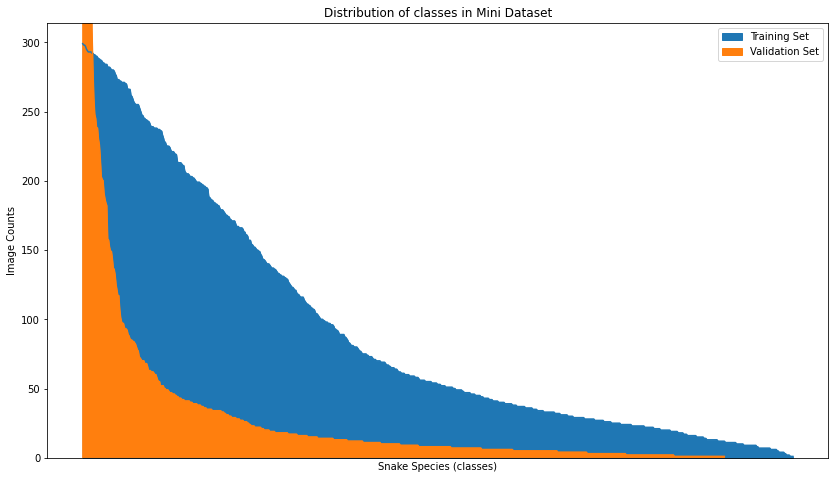

In [17]:
fig, ax = viz.create_fig(ncols=1, nrows=1, colsize=14, rowsize=8)
plot_class_distribution(mini_train_df, valid_df, title='Distribution of classes in Mini Dataset', ax=ax)
plt.show()

## Class Distribution in the Full Dataset (380k images)

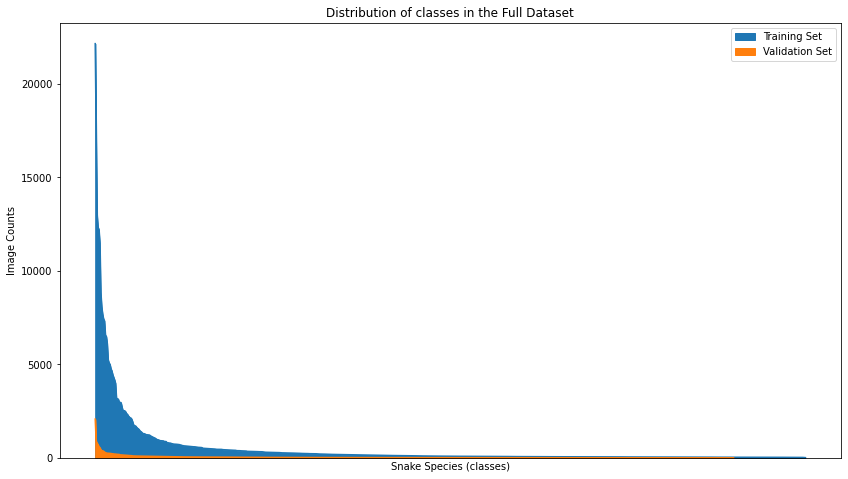

In [18]:
fig, ax = viz.create_fig(ncols=1, nrows=1, colsize=14, rowsize=8)
plot_class_distribution(train_df, valid_df, title='Distribution of classes in the Full Dataset', ax=ax)
plt.show()

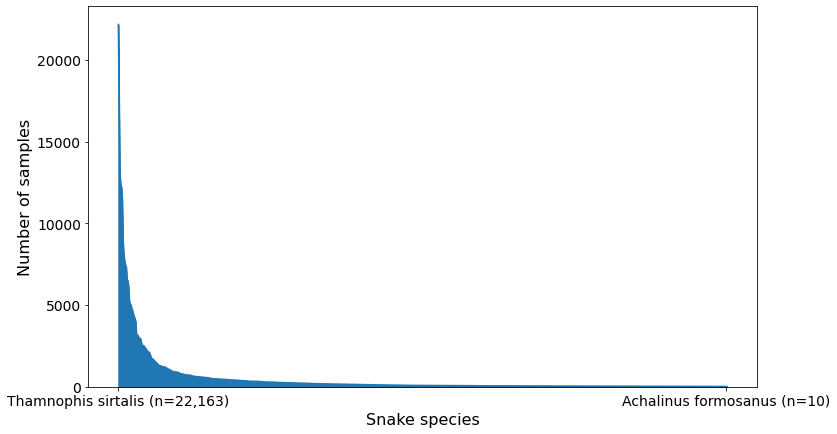

In [19]:
import matplotlib

vc = train_df['binomial'].value_counts()

fig, ax = viz.create_fig(ncols=1, nrows=1, colsize=12, rowsize=7)
vc.plot(kind='area', label='Training Set', ax=ax)
ax.set_xlabel('Snake species', fontsize=16)
ax.set_ylabel('Number of samples', fontsize=16)
# ax.set_title('Class Distribution in the SnakeCLEF Dataset', fontsize=16)
ax.set_xticks([0, 770])
ax.set_xticklabels([
    matplotlib.text.Text(0, 0, f'{vc.index[0]} (n={vc.iloc[0]:,d})'),
    matplotlib.text.Text(770, 0, f'{vc.index[-1]} (n={vc.iloc[-1]:,d})')], rotation=0, ha='center')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
fig.savefig('figures/snakeclef_class_distribution.png', bbox_inches='tight')

## Show Image Examples

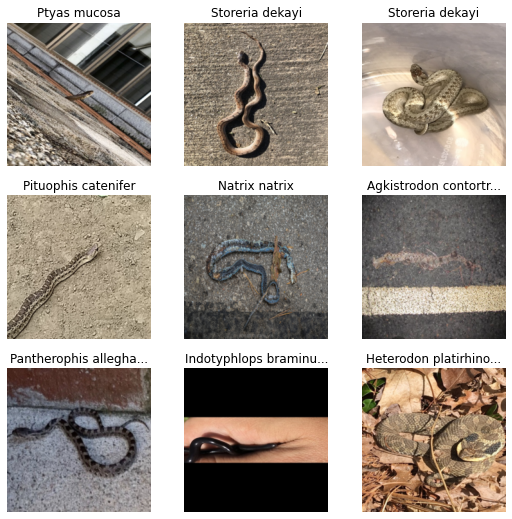

In [19]:
# create data loaders
trainloader = data.get_dataloader(
    train_df, img_path_col='image_path', label_col='binomial',
    path=DATA_DIR + TRAIN_SET_DIR)

trainloader.dataset.show_items()

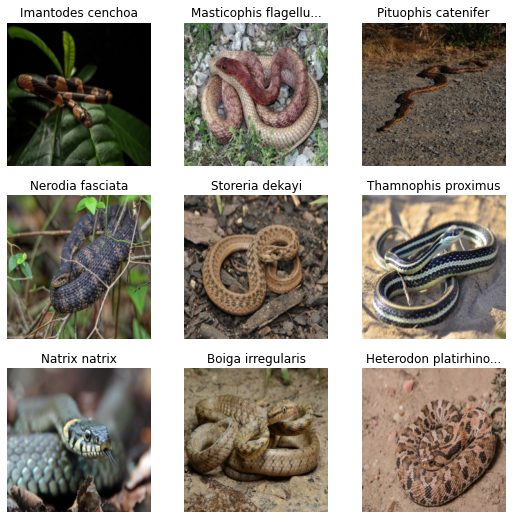

In [20]:
# create data loaders
validloader = data.get_dataloader(
    valid_df, img_path_col='file_path', label_col='binomial',
    path=DATA_DIR + 'test')

validloader.dataset.show_items()